In [2]:
def Classification(X, y):
    # Logistic Regression
    logistic = LogisticRegression(penalty='elasticnet', solver='saga', 
                              max_iter = 1e8, tol=1e-04, 
                              random_state = random_num)
    hyperp_logistic = {'l1_ratio' : [0, 0.25, 0.5, 0.75, 1],
                 'C' : [0.001, 0.01, 0.1, 0.5, 1, 2, 4]}
    grid_logistic = RandomizedSearchCV(logistic, hyperp_logistic, 
                             scoring='neg_mean_squared_error', cv=5, return_train_score=True)
    # non-linear SVM
    non_linear_SVM = SVC(gamma='scale', probability=True, 
                     max_iter = -1, tol=1e-04, 
                     decision_function_shape='ovr',
                     random_state = random_num)
    hyperp_non_linear_SVM = {'kernel' : ['poly', 'rbf', 'sigmoid'], 
                        'C' : [0.001, 0.01, 0.1, 0.5, 1, 2, 4], 
                        'degree': [2, 3, 4, 5]}
    grid_non_linear_SVM = RandomizedSearchCV(non_linear_SVM, hyperp_non_linear_SVM,
                             scoring='balanced_accuracy', cv=5, return_train_score=True)
    
    # Random Forest
    RF = RandomForestClassifier(bootstrap=True, n_estimators=100, random_state=random_num)
                                  
    hyperp_RF = {'criterion': ['gini', 'entropy'],
               'max_depth':[2,3,4,5,6,7],
               'min_samples_split':[2,4,6,8,10,20,40,60,100],
               'min_samples_leaf':[1,3,5,7,9],
               'max_features':[2,5,10,20,30,35,40]}                             
    grid_RF = RandomizedSearchCV(RF, hyperp_RF,
                    scoring='accuracy', cv=5, return_train_score=True)
    
    # GDBT
    GDBT = GradientBoostingClassifier(n_estimators=100, random_state=random_num)
                                  
    hyperp_GDBT = {'learning_rate': [0.15,0.1,0.05,0.01,0.005,0.001],
              'max_depth':[2,3,4,5,6,7],
              'min_samples_split':[2,4,6,8,10,20,40,60,100],
              'min_samples_leaf':[1,3,5,7,9],
              'max_features':[2,5,10,20,30,35,40],
              'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}                                 
    grid_GDBT = RandomizedSearchCV(GDBT, hyperp_GDBT,
                        scoring='accuracy', cv=5, return_train_score=True)
    
    logistic_model=grid_logistic.fit(X,y).best_estimator_
    non_linear_SVM_model=grid_non_linear_SVM.fit(X,y).best_estimator_
    GDBT_model = grid_GDBT.fit(X,y).best_estimator_
    RF_model = grid_RF.fit(X,y).best_estimator_
    models_list = [logistic_model, non_linear_SVM_model, GDBT_model, RF_model]
    
    logistic_y_pred = model_selection.cross_val_predict(logistic_model, X, y, cv=10,
                                                   method='predict')
    logistic_y_prob = model_selection.cross_val_predict(logistic_model, X, y, cv=10,
                                                   method='predict_proba')
    
    non_linear_SVM_y_pred = model_selection.cross_val_predict(non_linear_SVM_model, X, y, cv=10,
                                                   method='predict')
    non_linear_SVM_y_prob = model_selection.cross_val_predict(non_linear_SVM_model, X, y, cv=10,
                                                   method='predict_proba')
    
    GDBT_y_pred = model_selection.cross_val_predict(GDBT_model, X, y, cv=10,
                                                   method='predict')
    GDBT_y_prob = model_selection.cross_val_predict(GDBT_model, X, y, cv=10,
                                                   method='predict_proba')
    
    RF_y_pred = model_selection.cross_val_predict(RF_model, X, y, cv=10,
                                                   method='predict')
    RF_y_prob = model_selection.cross_val_predict(RF_model, X, y, cv=10,
                                                   method='predict_proba')
    
    y_pred = pd.DataFrame([y, logistic_y_pred, non_linear_SVM_y_pred, GDBT_y_pred, RF_y_pred],
                     index=["y_true","logistic", "non_linear_SVM", "GDBT", "RF"])
    y_pred.columns = X.index
    y_pred = y_pred.sort_values('y_true', axis=1)
    y_pred = y_pred.transpose()
    
    y_prob = pd.DataFrame([y, logistic_y_prob, non_linear_SVM_y_prob, GDBT_y_prob, RF_y_prob],
                     index=["y_true","logistic", "non_linear_SVM", "GDBT", "RF"])
    y_prob.columns = X.index
    y_prob = y_prob.sort_values('y_true', axis=1)
    y_prob = y_prob.transpose()
    return(y_pred, y_prob, models_list)

In [3]:
root="/projects/ohlab/ruoyun/MECFS/train_model/MECFS"

kegg_table_patient="kegg_gene_patient_control_table_for_classification.txt"
metabolomics_table_patient="metabolomics_patient_control_table_for_classification.csv"
kegg_table_onset="kegg_gene_onset_table_for_classification.txt"
metabolomics_table_onset="metabolomics_onset_table_for_classification.csv"

abundance_table="metaphlan3_specie_filtered_zscored_071020.csv"
meta_table="MECFS_metadata_lables_062320.csv"

In [4]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [6]:
#grid search
from sklearn.model_selection import RandomizedSearchCV

#save model
from joblib import dump, load

#validation
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import label_binarize

In [7]:
random_num = 1015

---

# import dataset here

In [8]:
rela_abun = pd.read_csv("%s/data/metagenomics/%s" %(root, abundance_table), 
                   index_col=0)
rela_abun_decode = rela_abun.iloc[:,:14]
rela_abun_data = rela_abun.iloc[:,14:]
print(rela_abun_decode.shape)
print(rela_abun_data.shape)

kegg_patient = pd.read_table("%s/result/feature_selection/%s" %(root, kegg_table_patient), 
                     sep='\t', index_col=0)
kegg_patient_decode = kegg_patient.iloc[:,:1]
kegg_patient_data = kegg_patient.iloc[:,1:]
print(kegg_patient_decode.shape)
print(kegg_patient_data.shape)

kegg_onset = pd.read_table("%s/result/feature_selection/%s" %(root, kegg_table_onset), 
                     sep='\t', index_col=0)
kegg_onset_decode = kegg_onset.iloc[:,:1]
kegg_onset_data = kegg_onset.iloc[:,1:]
print(kegg_onset_decode.shape)
print(kegg_onset_data.shape)

bioc_patient = pd.read_csv("%s/result/feature_selection/%s" %(root, metabolomics_table_onset), 
                   index_col=0)
bioc_patient_decode = bioc_patient.iloc[:,:12]
bioc_patient_data = bioc_patient.iloc[:,12:]
print(bioc_patient_decode.shape)
print(bioc_patient_data.shape)

bioc_onset = pd.read_csv("%s/result/feature_selection/%s" %(root, metabolomics_table_onset), 
                   index_col=0)
bioc_onset_decode = bioc_onset.iloc[:,:12]
bioc_onset_data = bioc_onset.iloc[:,12:]
print(bioc_onset_decode.shape)
print(bioc_onset_data.shape)

meta = pd.read_csv("%s/data/metadata/%s" %(root, meta_table), 
                   index_col=0)
meta_decode = meta.iloc[:, :4]
meta_data = meta.iloc[:, 4:]

print(meta_data.shape)

(169, 14)
(169, 224)
(1000, 1)
(1000, 224)
(1000, 1)
(1000, 224)
(400, 12)
(400, 184)
(400, 12)
(400, 184)
(5, 228)


# Patient vs Control

In [9]:
y_full = meta_data.loc['study_ptorhc', :]

In [11]:
X = rela_abun_data[:].transpose()
y = y_full[X.index].to_numpy()
abun_y_pred, abun_y_prob, abun_models = Classification(X, y)

In [ ]:
X = kegg_patient_data[:].transpose()
y = y_full[X.index].to_numpy()
kegg_y_pred, kegg_y_prob, kegg_models = Classification(X, y)

In [ ]:
X = bioc_patient_data[:].transpose()
y = y_full[X.index].to_numpy()
bioc_y_pred, bioc_y_prob, bioc_models = Classification(X, y)

In [ ]:
abun_y_pred.to_csv("%s/result/classification/abun_y_pred_patient.csv" %(root))
abun_y_prob.to_csv("%s/result/classification/abun_y_prob_patient.csv" %(root))
kegg_y_pred.to_csv("%s/result/classification/kegg_y_pred_patient.csv" %(root))
kegg_y_prob.to_csv("%s/result/classification/kegg_y_prob_patient.csv" %(root))
bioc_y_pred.to_csv("%s/result/classification/bioc_y_pred_patient.csv" %(root))
bioc_y_prob.to_csv("%s/result/classification/bioc_y_prob_patient.csv" %(root))

In [13]:
models = {
    'abundance' : abun_models,
    'metabolomics': bioc_models,
    'kegg' : kegg_models
}
dump(models, "%s/result/classification/patient_control_models_dictionary.joblib" %(root))

[LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=0.5, max_iter=100000000.0,
                    multi_class='auto', n_jobs=None, penalty='elasticnet',
                    random_state=1015, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False),
 SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=True, random_state=1015, shrinking=True,
     tol=0.0001, verbose=False),
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.05, loss='deviance', max_depth=7,
                            max_features=2, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=9, min_samples_split=20,
                            

# Onset

In [ ]:
y_full = meta_data.loc['illness_duration', :]

X = rela_abun_data[:].transpose()
y = y_full[X.index].to_numpy()
abun_y_pred, abun_y_prob, abun_models = Classification(X, y)

X = kegg_onset_data[:].transpose()
y = y_full[X.index].to_numpy()
kegg_y_pred, kegg_y_prob, kegg_models = Classification(X, y)

X = bioc_onset_data[:].transpose()
y = y_full[X.index].to_numpy()
bioc_y_pred, bioc_y_prob, bioc_models = Classification(X, y)

abun_y_pred.to_csv("%s/result/classification/abun_y_pred_onset.csv" %(root))
abun_y_prob.to_csv("%s/result/classification/abun_y_prob_onset.csv" %(root))
kegg_y_pred.to_csv("%s/result/classification/kegg_y_pred_onset.csv" %(root))
kegg_y_prob.to_csv("%s/result/classification/kegg_y_prob_onset.csv" %(root))
bioc_y_pred.to_csv("%s/result/classification/bioc_y_pred_onset.csv" %(root))
bioc_y_prob.to_csv("%s/result/classification/bioc_y_prob_onset.csv" %(root))

In [ ]:
models = {
    'abundance' : abun_models,
    'metabolomics': bioc_models,
    'kegg' : kegg_models
}
dump(models, "%s/result/classification/onset_models_dictionary.joblib" %(root))

# confusion matrix

Text(0.5, 0.98, 'y_pred_patient')

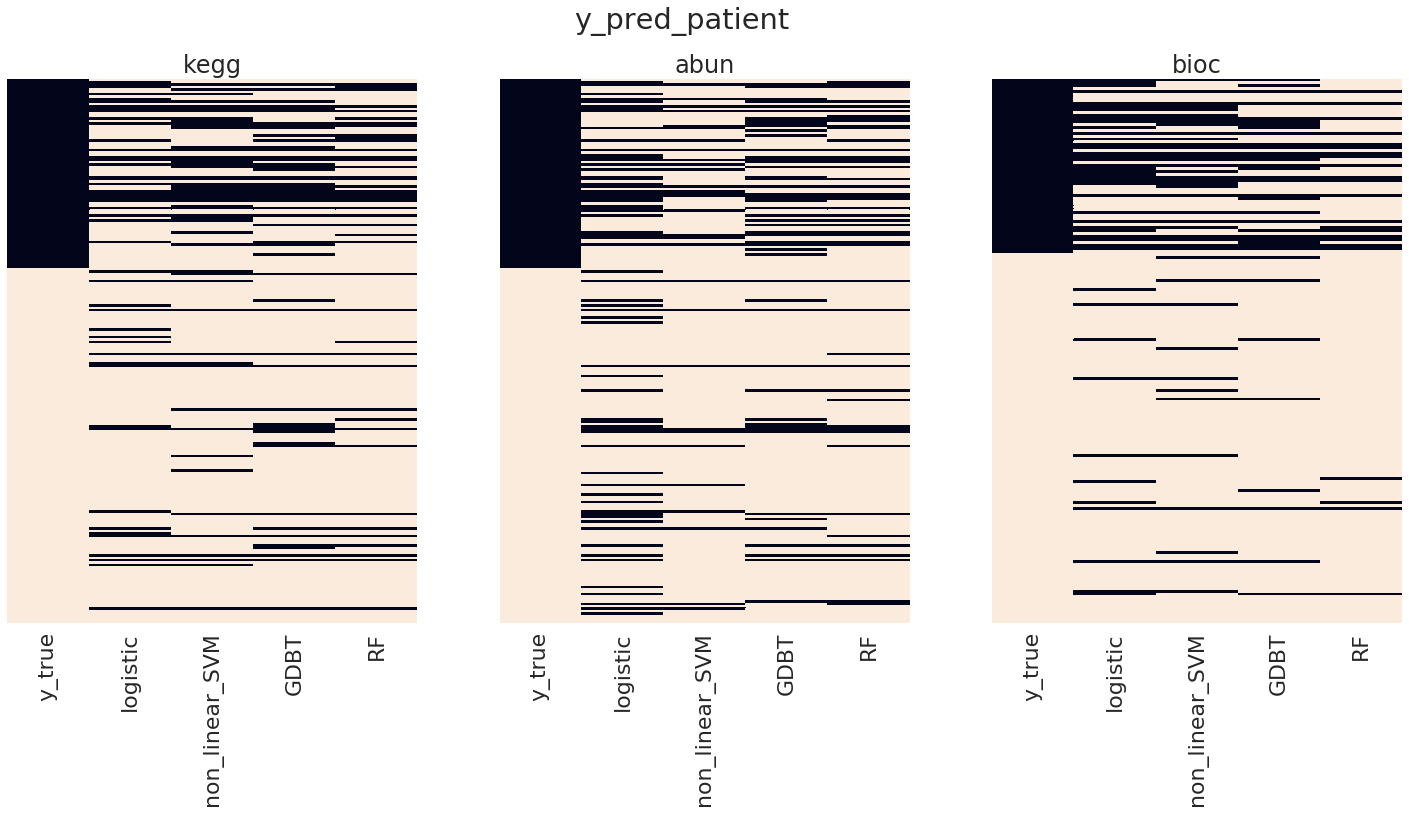

In [21]:
filenames = glob.glob("%s/result/classification/*_y_pred_patient.csv" %(root))
file = [pd.read_csv(f, index_col = 0) for f in filenames]

sns.set(style='white', font_scale=2)
fig = plt.figure(figsize=(25,10))

for i in range(len(filenames)):
    ax = fig.add_subplot(1, 3, i+1)
    title = filenames[i].split("/")[-1].split("_y_pred_patient.csv")[0]
    sns.heatmap(file[i], ax=ax, cbar=False)
    ax.set_title(title)
    plt.yticks([])
plt.suptitle('y_pred_patient')

Text(0.5, 0.98, 'y_pred_onset')

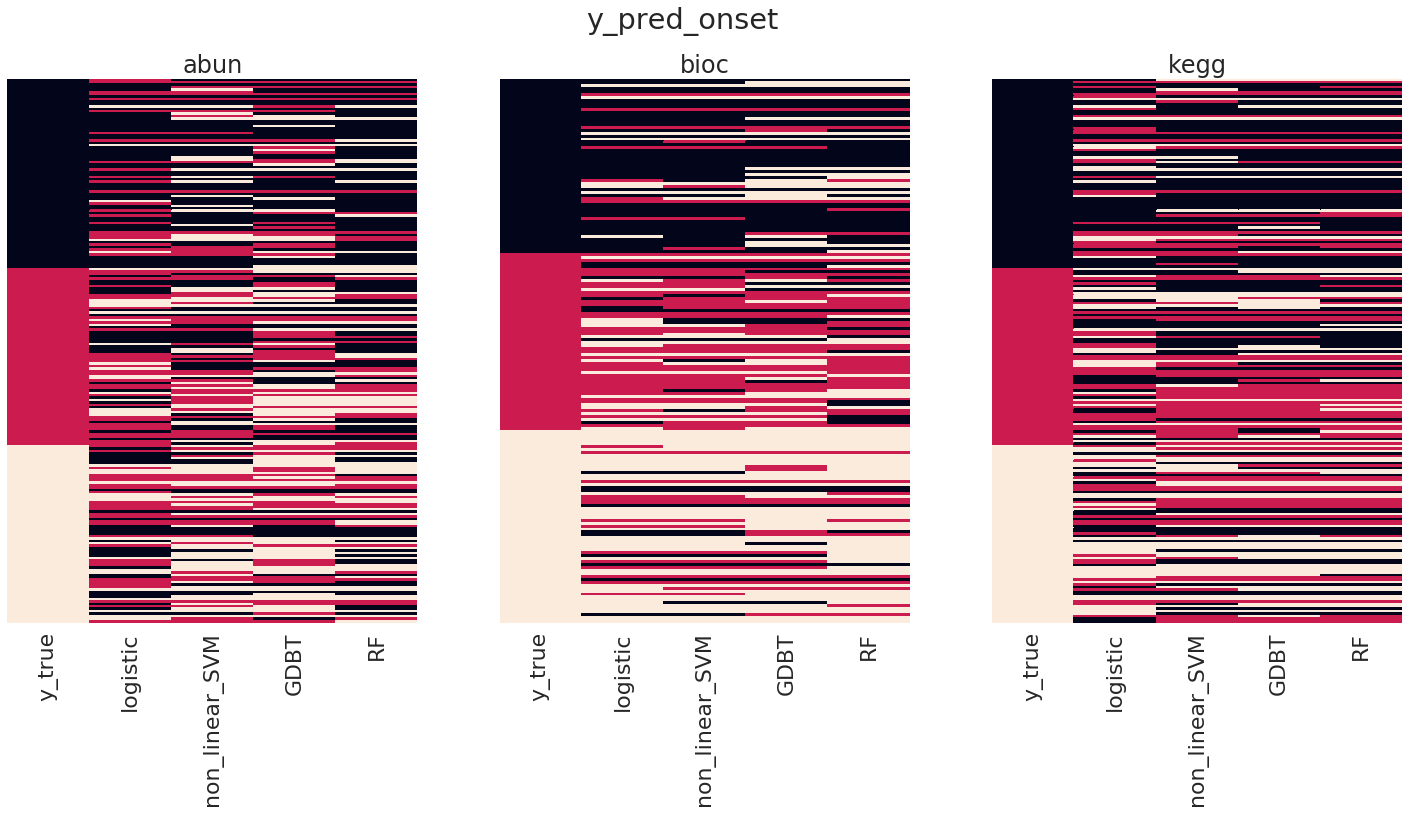

In [22]:
filenames = glob.glob("%s/result/classification/*_y_pred_onset.csv" %(root))
file = [pd.read_csv(f, index_col = 0) for f in filenames]

sns.set(style='white', font_scale=2)
fig = plt.figure(figsize=(25,10))

for i in range(len(filenames)):
    ax = fig.add_subplot(1, 3, i+1)
    title = filenames[i].split("/")[-1].split("_y_pred_onset.csv")[0]
    sns.heatmap(file[i], ax=ax, cbar=False)
    ax.set_title(title)
    plt.yticks([])
plt.suptitle('y_pred_onset')